In [122]:
import importlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyswarms.utils.plotters import plot_cost_history
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

import src.SI as SI
importlib.reload(SI)

<module 'src.SI' from 'c:\\Users\\seppe\\OneDrive\\Desktop\\Cursussen\\Big Data Algorithms\\Project\\BDA-project\\notebooks\\src\\SI.py'>

## Data

In [123]:
image = np.load("data/cropclustering/salinas_image.npy")
labels = np.load("data/cropclustering/salinas_labels.npy")

crop_type = ["Undefined", "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow","Fallow_rough_plow", "Fallow_smooth", "Stubble","Celery", "Grapes_untrained","Soil_vinyard_develop","Corn_senesced_green_weeds","Lettuce_romaine_4wk", "Lettuce_romaine_5wk",
        "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]

## Exploration

### RGB image

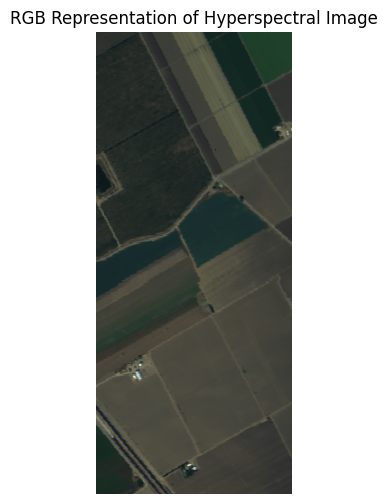

In [3]:
# Select the apporpriate bands for the RGB approximation
rgb_image = image[:, :, [29, 19, 9]]  

# Normalize the image for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(rgb_image)
plt.title("RGB Representation of Hyperspectral Image")
plt.axis("off")
plt.show()

### Other non-RGB spectral bands

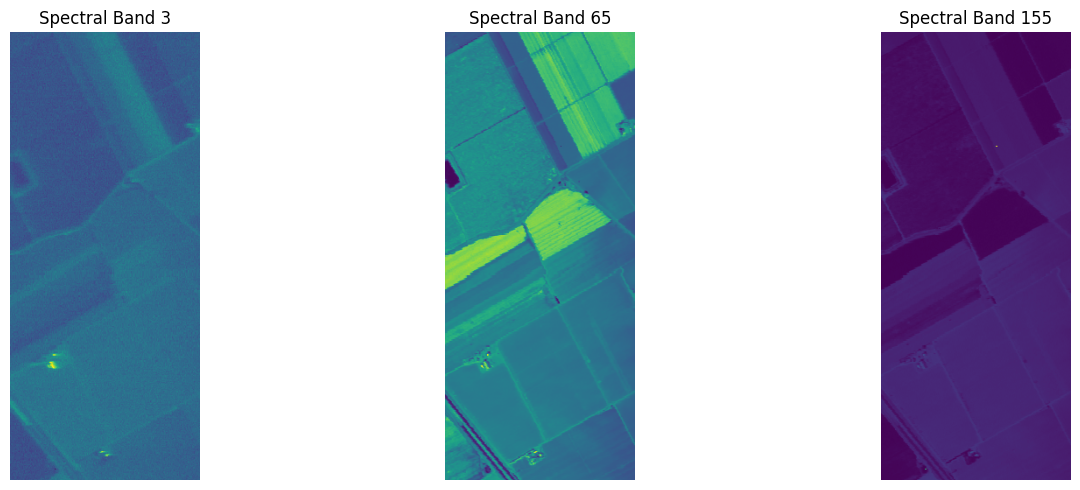

In [4]:
channel3 = image[:, :, 2]    # 3rd spectral band
channel65 = image[:, :, 64]  # 65th spectral band
channel155 = image[:, :, 154] # 155th spectral band

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each channel with a title
axes[0].imshow(channel3)
axes[0].set_title("Spectral Band 3")

axes[1].imshow(channel65)
axes[1].set_title("Spectral Band 65")

axes[2].imshow(channel155)
axes[2].set_title("Spectral Band 155")

# Remove axis ticks
for ax in axes:
    ax.axis("off")

# Show the plots
plt.tight_layout()
plt.show()

### Labels

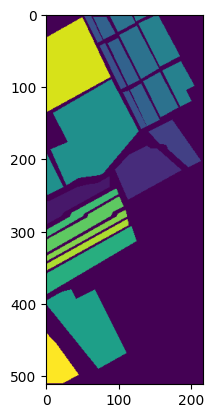

In [5]:
plt.imshow(labels)

### Some statistics

In [6]:
# Get image dimensions and spectral bands
height, width, spectral_bands = image.shape
print(f"Image Dimensions: {height} x {width}")
print(f"Number of Spectral Bands: {spectral_bands}\n")

# Unique crop categories
unique_labels = np.unique(labels)
num_classes = len(unique_labels)
print(f"Total Unique Crop Types: {num_classes}")

# Count the number of pixels per crop type
pixel_counts = np.bincount(labels.ravel())

# Display pixel distribution per crop type
print("\nPixel Count per Crop Type:")
unique, counts = np.unique(labels, return_counts = True)
for i, count in enumerate(pixel_counts):
    print(f"{crop_type[unique[i]]}: {count} pixels")

Image Dimensions: 512 x 217
Number of Spectral Bands: 204

Total Unique Crop Types: 17

Pixel Count per Crop Type:
Undefined: 56975 pixels
Brocoli_green_weeds_1: 2009 pixels
Brocoli_green_weeds_2: 3726 pixels
Fallow: 1976 pixels
Fallow_rough_plow: 1394 pixels
Fallow_smooth: 2678 pixels
Stubble: 3959 pixels
Celery: 3579 pixels
Grapes_untrained: 11271 pixels
Soil_vinyard_develop: 6203 pixels
Corn_senesced_green_weeds: 3278 pixels
Lettuce_romaine_4wk: 1068 pixels
Lettuce_romaine_5wk: 1927 pixels
Lettuce_romaine_6wk: 916 pixels
Lettuce_romaine_7wk: 1070 pixels
Vinyard_untrained: 7268 pixels
Vinyard_vertical_trellis: 1807 pixels


## Preprocessing

### Restructuring

In [124]:
# Reshape the hyperspectral image and labels
reshaped_image = image.reshape(-1, image.shape[-1], order='C')
reshaped_labels = labels.ravel(order='C')

# Remove "Undefined" category (label 0)
valid_indices = reshaped_labels != 0
data = reshaped_image[valid_indices]
labels = reshaped_labels[valid_indices]

### Dimensionality reduction

In [125]:
scaled = StandardScaler().fit_transform(data)
tsne = TSNE(n_components=2, random_state=42, perplexity=100, n_iter=1000)
tsne_crops = tsne.fit_transform(scaled)  
tsne_crops = np.hstack((labels.reshape(-1,1), tsne_crops))
np.save('data/cropclustering/tsne_crops.npy', tsne_crops)

c:\Users\seppe\OneDrive\Desktop\Cursussen\Big Data Algorithms\Project\BDA-project\.env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


## Clustering

In [127]:
tsne_crops = np.load("data/cropclustering/tsne_crops.npy")
input_data = tsne_crops[:, 1:]
true_labels = labels
n_clusters = 16

results = pd.DataFrame(columns=['Accuracy'])

In [128]:
# Code to translate arbitrary predicted labels to match ground truth labels
from munkres import Munkres

def make_cost_matrix(c1, c2):
    uc1, uc2 = np.unique(c1), np.unique(c2)
    assert uc1.size == uc2.size and np.all(uc1 == uc2)

    m = np.ones([uc1.size, uc2.size])
    for i, val_i in enumerate(uc1):
        it_i = np.nonzero(c1 == val_i)[0]
        for j, val_j in enumerate(uc2):
            it_j = np.nonzero(c2 == val_j)[0]
            m[i, j] = -np.intersect1d(it_i, it_j).size
    return m

def translate_predicted_labels(predicted_y, y):
    cost_matrix = make_cost_matrix(predicted_y, y)
    indexes = Munkres().compute(cost_matrix)
    mapper = {old: new for (old, new) in indexes}
    
    for old, new in mapper.items():
        print(f"Mapping cluster {old} → Class {new}")

    return np.array([mapper[i] for i in predicted_y])

In [129]:
# Run K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(input_data)

kmeans_centers = kmeans.cluster_centers_

In [130]:
translated_kmeans_labels = translate_predicted_labels(kmeans_labels, true_labels - 1)
results.loc["K-Means"] = accuracy_score(true_labels - 1, translated_kmeans_labels)

Mapping cluster 0 → Class 7
Mapping cluster 1 → Class 12
Mapping cluster 2 → Class 1
Mapping cluster 3 → Class 11
Mapping cluster 4 → Class 14
Mapping cluster 5 → Class 13
Mapping cluster 6 → Class 5
Mapping cluster 7 → Class 8
Mapping cluster 8 → Class 6
Mapping cluster 9 → Class 9
Mapping cluster 10 → Class 3
Mapping cluster 11 → Class 4
Mapping cluster 12 → Class 10
Mapping cluster 13 → Class 15
Mapping cluster 14 → Class 2
Mapping cluster 15 → Class 0


In [ ]:
iters = 100

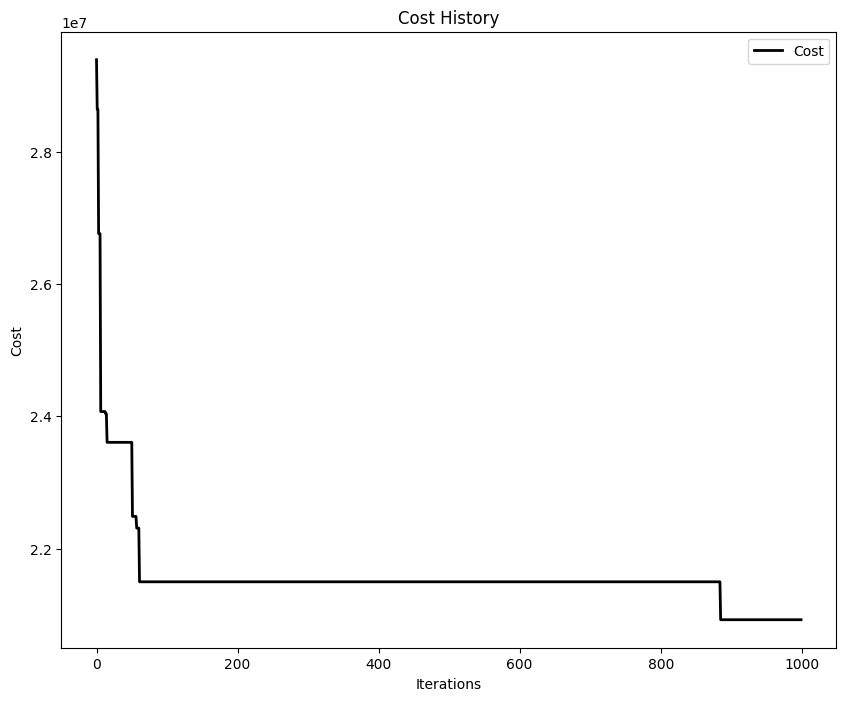

In [150]:
# Run PSO
pso_cost, pso_centers, pso_labels, pso_pos_history, pso_cost_history, pso_best_centers_history = SI.run_pso(input_data, n_clusters, iters, n_particles=30, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, record_history=True)

plot_cost_history(cost_history=pso_cost_history)
plt.show()

In [151]:
translated_pso_labels = translate_predicted_labels(pso_labels, true_labels - 1)
results.loc["PSO"] = accuracy_score(true_labels - 1, translated_pso_labels)

Mapping cluster 0 → Class 6
Mapping cluster 1 → Class 5
Mapping cluster 2 → Class 3
Mapping cluster 3 → Class 8
Mapping cluster 4 → Class 15
Mapping cluster 5 → Class 9
Mapping cluster 6 → Class 7
Mapping cluster 7 → Class 0
Mapping cluster 8 → Class 12
Mapping cluster 9 → Class 4
Mapping cluster 10 → Class 1
Mapping cluster 11 → Class 13
Mapping cluster 12 → Class 14
Mapping cluster 13 → Class 11
Mapping cluster 14 → Class 10
Mapping cluster 15 → Class 2


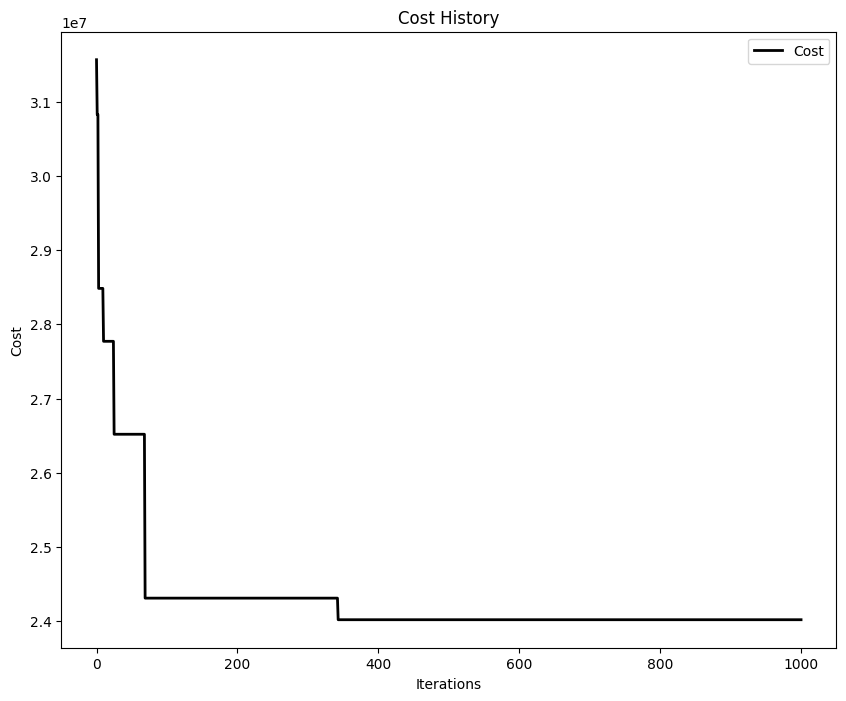

In [153]:
# Run ABC
abc_cost, abc_centers, abc_labels, abc_history = SI.run_abc(
    input_data, n_clusters=n_clusters, iters=iters, n_food_sources=30, limit=20, record_history=True
)

plot_cost_history(cost_history=abc_history["costs"])
plt.show()

In [154]:
translated_abc_labels = translate_predicted_labels(abc_labels, true_labels - 1)
results.loc["ABC"] = accuracy_score(true_labels - 1, translated_abc_labels)

AssertionError: 

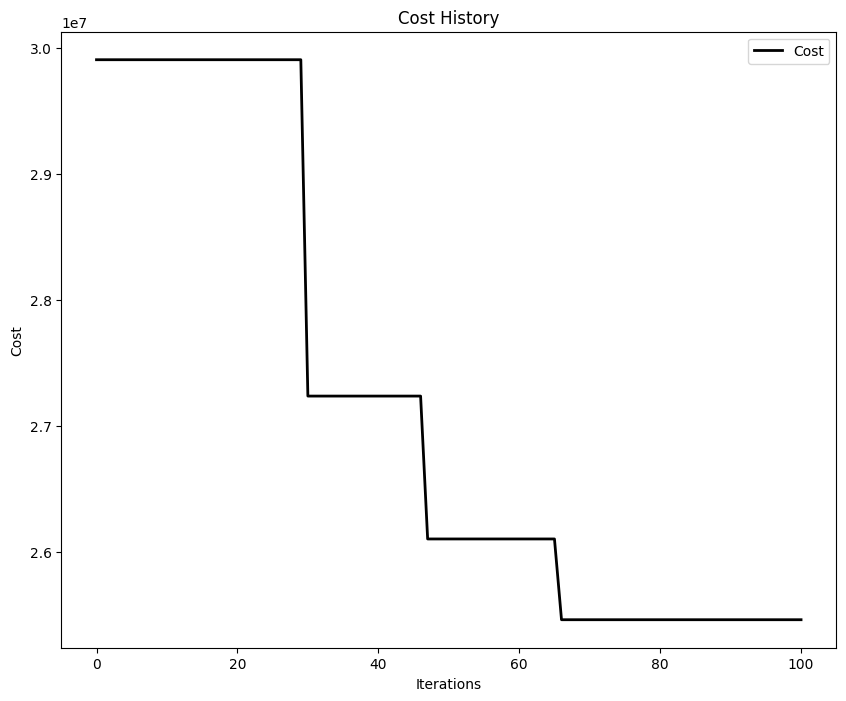

In [ ]:
# Run ACOR (ACO variant)
acor_cost, acor_centers, acor_labels, acor_history = SI.run_acor(
    input_data, n_clusters=n_clusters, iters=iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True
)

plot_cost_history(cost_history=acor_history["costs"])
plt.show()

In [137]:
translated_acor_labels = translate_predicted_labels(acor_labels, true_labels - 1)
results.loc["ACOR"] = accuracy_score(true_labels - 1, translated_acor_labels)

Mapping cluster 0 → Class 13
Mapping cluster 1 → Class 11
Mapping cluster 2 → Class 3
Mapping cluster 3 → Class 10
Mapping cluster 4 → Class 9
Mapping cluster 5 → Class 8
Mapping cluster 6 → Class 15
Mapping cluster 7 → Class 12
Mapping cluster 8 → Class 0
Mapping cluster 9 → Class 14
Mapping cluster 10 → Class 5
Mapping cluster 11 → Class 4
Mapping cluster 12 → Class 6
Mapping cluster 13 → Class 2
Mapping cluster 14 → Class 7
Mapping cluster 15 → Class 1


## Results

In [138]:
results.head()

,Accuracy
K-Means,0.573814
PSO,0.573482
ABC,0.630087
ACOR,0.475678


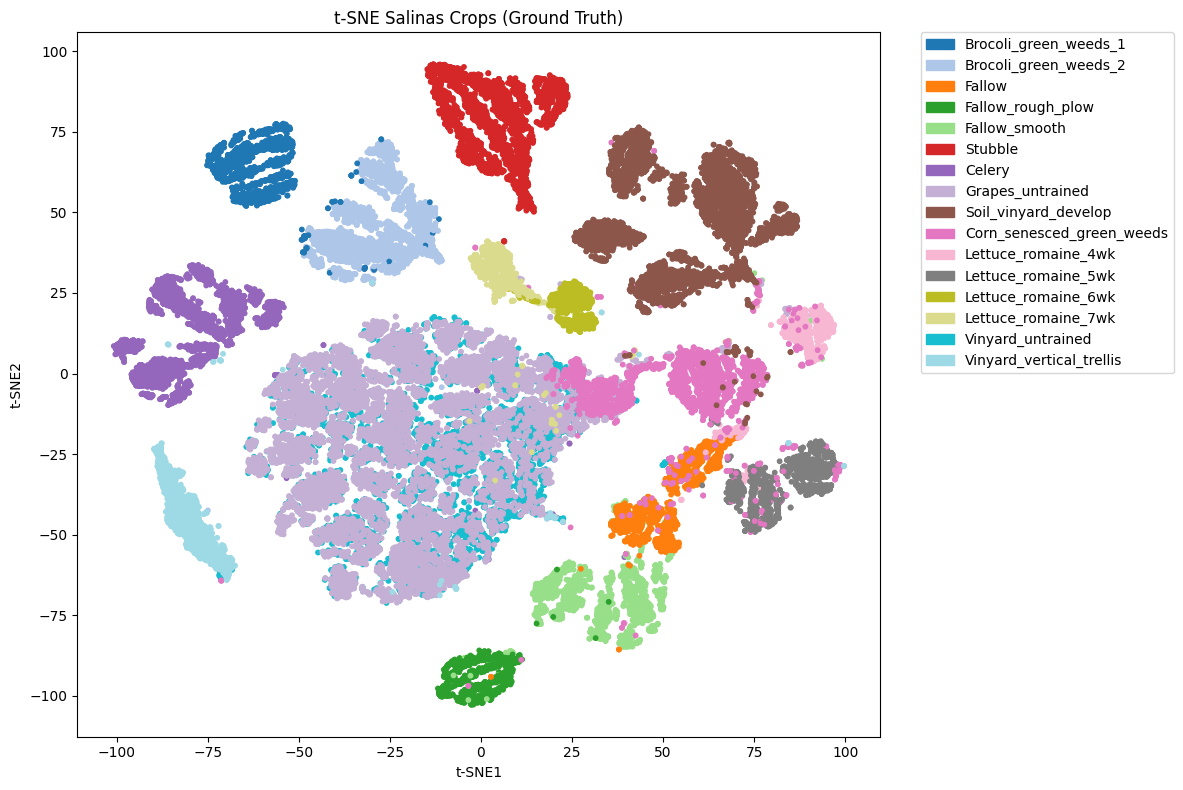

In [148]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_crops[:, 1], tsne_crops[:, 2], c=tsne_crops[:, 0], cmap='tab20', s=10)
plt.title('t-SNE Salinas Crops (Ground Truth)')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=crop_type[i]) for i in range(1, len(crop_type))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

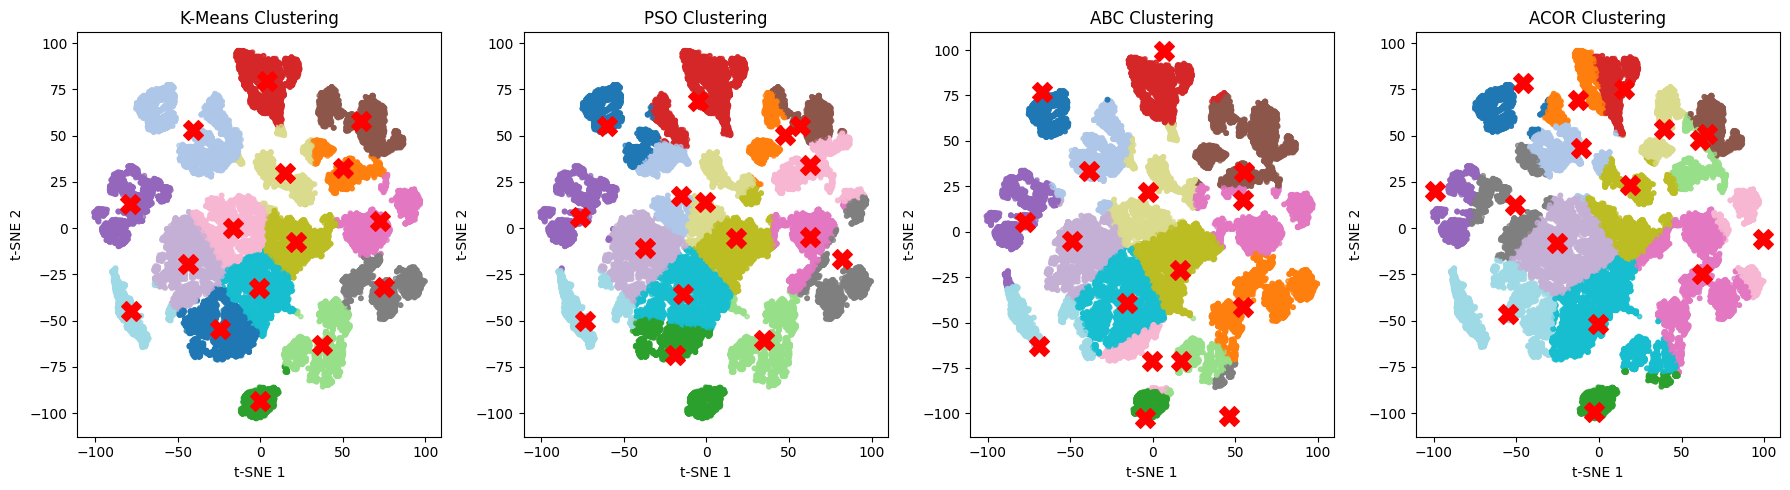

In [147]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.scatter(tsne_crops[:, 1], tsne_crops[:, 2], c=translated_kmeans_labels, cmap='tab20', alpha=0.7, s=10)
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', s=200, marker='X')
plt.title("K-Means Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 4, 2)
plt.scatter(tsne_crops[:, 1], tsne_crops[:, 2], c=translated_pso_labels, cmap='tab20', alpha=0.7, s=10)
plt.scatter(pso_centers[:, 0], pso_centers[:, 1], c='red', s=200, marker='X')
plt.title("PSO Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 4, 3)
plt.scatter(tsne_crops[:, 1], tsne_crops[:, 2], c=translated_abc_labels, cmap='tab20', alpha=0.7, s=10)
plt.scatter(abc_centers[:, 0], abc_centers[:, 1], c='red', s=200, marker='X')
plt.title("ABC Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 4, 4)
plt.scatter(tsne_crops[:, 1], tsne_crops[:, 2], c=translated_acor_labels, cmap='tab20', alpha=0.7, s=10)
plt.scatter(acor_centers[:, 0], acor_centers[:, 1], c='red', s=200, marker='X')
plt.title("ACOR Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()